In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the Keras libraries and other packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, Activation
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
import pandas as pd
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.models import load_model
from tensorflow.keras import applications
from tensorflow.keras import optimizers

In [3]:
img_width, img_height = 224, 224
train_data_dir = r'D:\Code\Project-ML\Image_Classification\Dataset\train'
validation_data_dir = r'D:\Code\Project-ML\Image_Classification\Dataset\test'

In [4]:
model = applications.VGG16(weights = 'imagenet',
                           include_top=False,
                           input_shape = (img_width, img_height, 3))

In [5]:
for layer in model.layers[:6]:
    layer.trainable = True

In [6]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

In [7]:
model_final = Model(inputs = model.input, outputs= predictions)

In [8]:
model_final.compile(loss = 'categorical_crossentropy',
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                    metrics=['accuracy'])

In [9]:
# Part 2 - Read and pre-preocess images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    batch_size = 32, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    class_mode = "categorical")

Found 8048 images belonging to 2 classes.
Found 1637 images belonging to 2 classes.


In [11]:
checkpoint = ModelCheckpoint(r"D:\Code\Project-ML\Image_Classification\Save_Model_h5\transfer_fish_plasticwaste_VGG16.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq=1)
early = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')

In [12]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
import datetime
t0 = datetime.datetime.now()
print(t0)

2023-04-27 02:26:52.180972


In [14]:
history = model_final.fit(train_generator, 
                          epochs=100,
                          validation_data = validation_generator,
                          verbose = 1,
                          callbacks = [checkpoint, early])

Epoch 1/100
252/252 [==============================] - 313s 1s/step - loss: 0.4324 - accuracy: 0.7816 - val_loss: 0.0997 - val_accuracy: 0.9658
Epoch 2/100
252/252 [==============================] - 144s 570ms/step - loss: 0.1878 - accuracy: 0.9272 - val_loss: 0.0487 - val_accuracy: 0.9847
Epoch 3/100
252/252 [==============================] - 144s 570ms/step - loss: 0.1490 - accuracy: 0.9418 - val_loss: 0.0351 - val_accuracy: 0.9835
Epoch 4/100
252/252 [==============================] - 147s 582ms/step - loss: 0.1174 - accuracy: 0.9568 - val_loss: 0.0332 - val_accuracy: 0.9872
Epoch 5/100
252/252 [==============================] - 182s 721ms/step - loss: 0.0973 - accuracy: 0.9620 - val_loss: 0.0234 - val_accuracy: 0.9908
Epoch 6/100
252/252 [==============================] - 165s 651ms/step - loss: 0.0892 - accuracy: 0.9678 - val_loss: 0.0275 - val_accuracy: 0.9896
Epoch 7/100
252/252 [==============================] - 144s 570ms/step - loss: 0.0827 - accuracy: 0.9679 - val_loss: 0.02

In [15]:
t1 = datetime.datetime.now()
print(t1-t0)

2:06:30.734412


In [16]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
45,0.015111,0.995278,0.015320,0.995113
46,0.013843,0.995154,0.030498,0.989004
47,0.015846,0.994409,0.022987,0.993891
48,0.012649,0.995527,0.013455,0.994502
49,0.015572,0.994533,0.019798,0.993891


<Axes: >

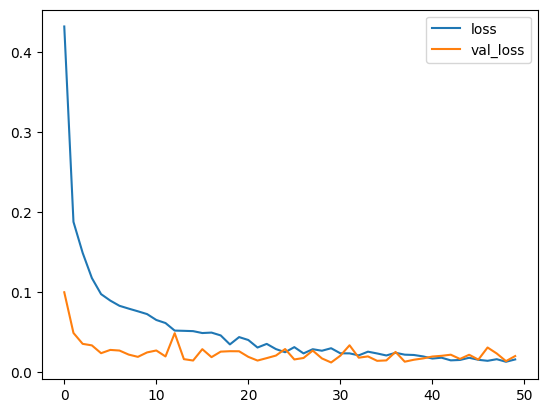

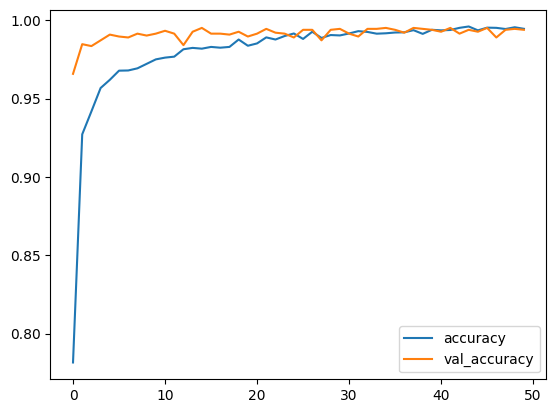

In [17]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

#### Nhận xét:
- Model đạt valid_accuracy tương đối ~ 93.34%
- => Thử thêm model khác: inception_resnet_v2, .v.v.

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [19]:
#save model
model_final.save(r'D:\Code\Project-ML\Image_Classification\Save_Model_h5\transfer_fish_plasticwaste_VGG16_model.h5')
print('save!!!')

save!!!


In [20]:
model = load_model(r'D:\Code\Project-ML\Image_Classification\Save_Model_h5\transfer_fish_plasticwaste_VGG16_model.h5')

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [22]:
def result(test_image):
    test_image = image.img_to_array(test_image)
    test_image = test_image/255
    test_image = np.expand_dims(test_image, axis= 0)
    result = model.predict(test_image)

    # 0 la fish, 1 la plastic, nguong sigmoid = 0.5
    if result[0][0] >= 0.5:
        prediction = 'Fish'
    else:
        prediction = 'PlasticWaste'
    return prediction

In [23]:
train_evaluation= model.evaluate(train_generator)
test_evaluation= model.evaluate(validation_generator)
print('Train Accuracy:', round(train_evaluation[1], 4), 
        '; Train loss:', round(train_evaluation[0], 4))
print('Test Accuracy:', round(test_evaluation[1], 4), 
        '; Test loss:', round(test_evaluation[0], 4))

52/52 [==============================] - 10s 180ms/step - loss: 0.0198 - accuracy: 0.9939
Train Accuracy: 0.9952 ; Train loss: 0.0146
Test Accuracy: 0.9939 ; Test loss: 0.0198


In [24]:
import os 
predict_path= r'D:\Code\Project-ML\Image_Classification\Dataset\single_prediction\\'
list_image= os.listdir(predict_path)

In [25]:
df= pd.DataFrame(columns=['name_file', 'truth', 'predict'])
name_file=[]
truth=[]
predict=[]

In [26]:
for i in range(len(list_image)):
    path= predict_path + list_image[i]
    test_img= image.load_img(path, target_size=[img_width, img_height])
    name_file.append(list_image[i])
    truth.append(list_image[i].split('_')[0])
    predict.append(result(test_img))

df['name_file']= name_file
df['truth']= truth
df['predict']= predict
df.to_csv(r'D:\Code\Project-ML\Computer_Vision\Pre-trained_Model\Resnet50_v2\prediction_fish_and_plasticwaste_VGG16.csv')

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
confusion_matrix(df['truth'], df['predict'])

array([[50,  0],
       [ 4, 46]], dtype=int64)

In [29]:
print(classification_report(df['truth'], df['predict']))

              precision    recall  f1-score   support

        Fish       0.93      1.00      0.96        50
PlasticWaste       1.00      0.92      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

